In [1]:
import sys
import IPython.display

In [2]:
sys.path.insert(0, "/home/mai/zkhan/ALBEF")

In [89]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

In [58]:
from models.tokenization_bert import BertTokenizer
from models.singlestream_v2.baseline_retrieval import ALBEF
from models.vit import interpolate_pos_embed

In [5]:
import json
import random
import ruamel.yaml as yaml
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import spacy

In [170]:
from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, thresh)] = 0
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, 90)] = 0
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.9).reshape(attMap.shape + (1,))*img + (attMap**0.9).reshape(attMap.shape+(1,)) * attMapV
    return attMap

In [171]:
def getMaskedAttMap(img, attMap, blur = True, overlap = True, mask=None):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, thresh)] = 0
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if mask is not None:
        mask = skimage_transform.resize(mask, (img.shape[:2]), order = 3, mode = 'constant')
        mask = np.expand_dims(mask, -1).repeat(3, -1).shape
        img *= mask
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    #attMap[attMap < np.percentile(attMap, 90)] = 0
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.9).reshape(attMap.shape + (1,))*img + (attMap**0.9).reshape(attMap.shape+(1,)) * attMapV
    return attMap

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
from dataset.utils import pre_caption

In [74]:
with open('/net/acadia10a/data/zkhan/coco2017/pretrain-pairs.json', 'r') as f:
    coco = json.load(f)

In [61]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((384,384),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((384,384),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/ablations/Pretrain4M_SharedTxtEncoder.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/mai/zkhan/ALBEF/configs/shared_bert.json'
config['image_res'] = 384

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_pseudolabels_multimodal_mim_momentum/checkpoint_29.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder)
pos_embed_reshaped_m = interpolate_pos_embed(state_dict['visual_encoder_m.pos_embed'],model.visual_encoder_m)   
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped
state_dict['visual_encoder_m.pos_embed'] = pos_embed_reshaped_m
for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]                
msg = model.load_state_dict(state_dict,strict=False) 

device = torch.device('cuda')
model.eval();
model = model.to(device)

reshape position embedding from 196 to 576
_IncompatibleKeys(missing_keys=['mask_token'], unexpected_keys=['head.weight', 'head.bias'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.pooler.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from t

Some weights of BertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.11.crossattention.output.dense.weight', 'bert.encoder.layer.8.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.2.crossattention.output.dense.bias', 'bert.encoder.layer.4.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.9.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.7.crossattention.self.value.bias', 'bert.encoder.layer.1.crossattention.self.value.weight', 'bert.encoder.layer.5.crossattention.output.dense.bias', 'bert.encoder.layer.6.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.output.dense.bias', 'bert.encoder.layer.2.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.2.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.query.weight'

reshape position embedding from 256 to 576
reshape position embedding from 256 to 576


two baseball players on a base ball field


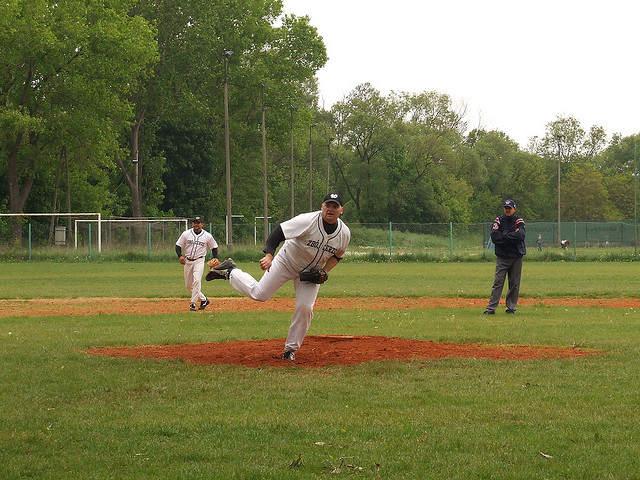

In [279]:
sample = random.choice(coco)
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [280]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

In [281]:
caption = pre_caption(sample['caption'], 30)
caption

'two baseball players on a base ball field'

In [282]:
image = image.to(device)

In [283]:
image_embeds = model.visual_encoder(image.unsqueeze(0), register_blk=11)
image_embeds.shape

torch.Size([1, 577, 768])

In [284]:
self_att_i = model.visual_encoder.blocks[11].attn.get_attention_map()
self_att_i.shape

torch.Size([1, 12, 577, 577])

In [285]:
nh = self_att_i.shape[1]
attentions = self_att_i[0, :, 0, 1:].reshape(nh, -1).cpu()

In [286]:
N_PATCHES = 24
PATCH_SZ = 16
attentions_raw = attentions
attentions = attentions.detach().reshape(nh, N_PATCHES, N_PATCHES) # reshape it back into a grid based on the # of patches
attentions = F.interpolate(attentions.unsqueeze(0), scale_factor=PATCH_SZ, mode="nearest")[0].cpu().numpy()

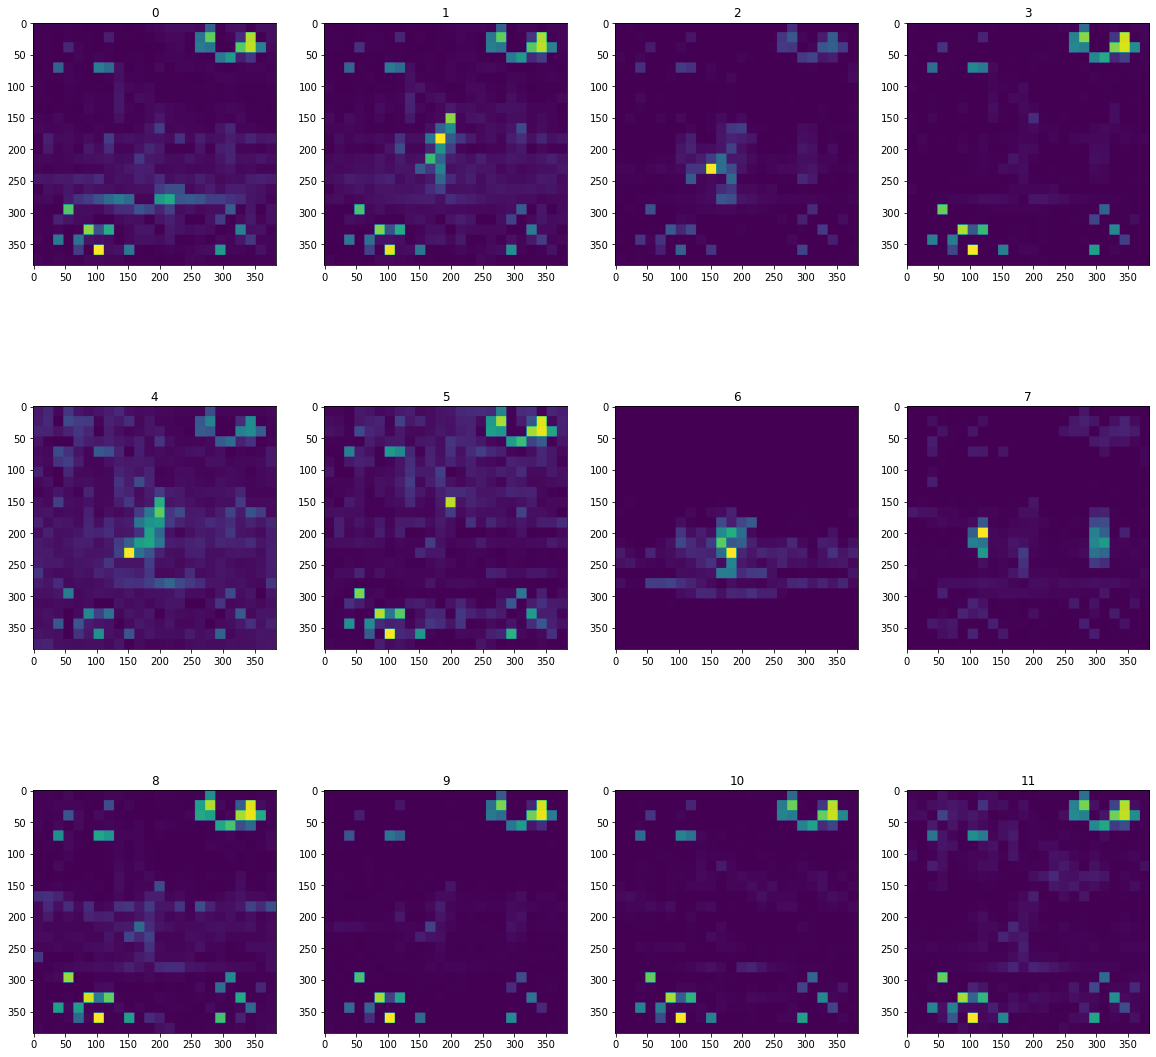

In [287]:
fig, (axes) = plt.subplots(ncols=4, nrows=3, figsize=(20, 20))
img = view_image
axes = axes.flatten()
#torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
    attMap = attentions[j]
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap -= attMap.min()
    attMap /= attMap.max()
    #axes[j].axhline(j)
    axes[j].imshow(attMap, cmap='viridis')
    axes[j].set_title(j)

In [288]:
image_atts = torch.ones(image_embeds.shape[:-1]).to(device)
image_atts.shape

torch.Size([1, 577])

In [289]:
#patchwise_img_feats = F.normalize(model.vision_proj(image_embeds).squeeze(), dim=-1)
patchwise_img_feats = F.normalize(image_embeds.squeeze(), dim=-1)

In [293]:
search_word = 'player' #sample['caption']
with torch.no_grad():
    text = tokenizer(search_word, padding='longest', truncation=True, max_length=25, return_tensors='pt').to(device)
    text_embeds = model.text_encoder(
        text.input_ids,
        attention_mask=text.attention_mask,
        return_dict=True,
        mode='text'
    )
    txt_feat = F.normalize(model.text_proj(text_embeds.last_hidden_state[:,1,:]).squeeze(), dim=-1)
    txt_feat = F.normalize(text_embeds.last_hidden_state[:,0,:].squeeze(), dim=-1)

Text(0.5, 1.0, 'Patches closest to player')

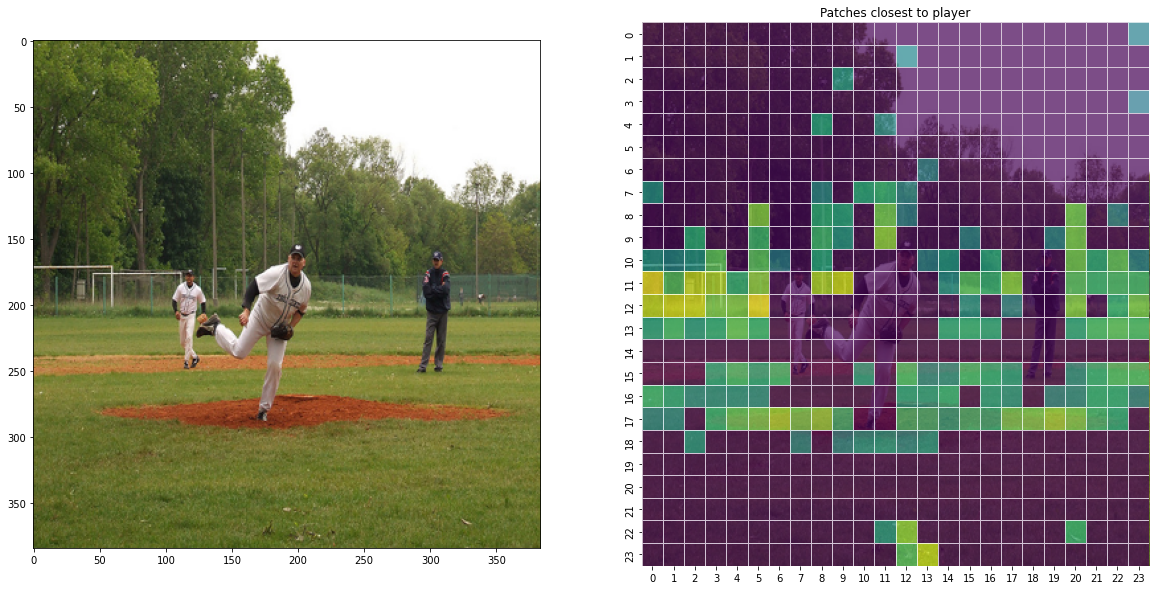

In [294]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sim_map = (txt_feat @ patchwise_img_feats.T).detach().cpu().numpy()[1:].reshape(24, 24)
threshold = np.percentile(sim_map.flatten(), 75)
sim_map[sim_map < threshold] = 0
sim_map -= sim_map.min()
sim_map = sim_map / sim_map.max()
sns.heatmap(sim_map, cbar=False, ax=ax2, zorder=5, linewidths=.5, alpha=.7, cmap='viridis')
ax2.imshow(view_image.permute(1,2,0),
          aspect = ax2.get_aspect(),
          extent = ax2.get_xlim() + ax2.get_ylim(),
          zorder = 1) #put the map under the heatmap
ax1.imshow(view_image.permute(1,2,0))
plt.title(f'Patches closest to {search_word}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


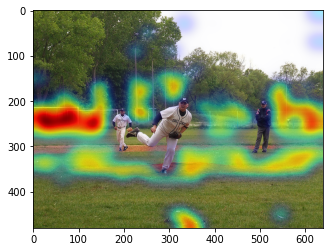

In [295]:
rgb_image = cv2.imread(sample['image'])[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255
plt.imshow(getAttMap(rgb_image, sim_map, blur=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


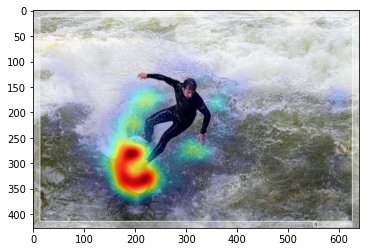

In [246]:
plt.imshow(getAttMap(rgb_image, attentions[6], blur=True))

In [212]:
patchwise_img_feats.shape

torch.Size([577, 768])

In [235]:
word_embeddings = F.normalize(model.text_encoder.embeddings.word_embeddings.weight, dim=-1)

In [272]:
head = 2
head_mean = (attentions_raw[head] * patchwise_img_feats[1:].T.cpu()).T.mean(axis=0)

In [273]:
closest_tokens = (head_mean.cuda() @ word_embeddings.T).topk(10).indices.detach().cpu()

In [274]:
for _ in closest_tokens:
    print(tokenizer.decode([_]))

##hab
industry
notice
coastline
put
art
sketch
##ha
note
##ilia
